In [ ]:
''' 
PPCA 1.0 Data download : GHS and OSM data acquisition

This script facilitates the acquisition of spatial data using a combination of Google Earth Engine, OpenStreetMap, and QGIS tools. 
It starts by authenticating and initializing Earth Engine and downloading Global Human Settlement (GHS) raster data for a specified year. 
The GHS data is then exported as a raster image for a defined geographical area. Once downloaded, the raster data is converted to vector data using
QGIS and saved in a local GeoPackage. The script proceeds to extract building data within the same geographical area from OpenStreetMap, cleans the
data by removing any list-type columns, and saves the cleaned data into the GeoPackage. Additionally, the script extracts street data from 
OpenStreetMap, converting it into a GeoDataFrame format and filtering it to separate pedestrian streets from primary roads. Both sets of street data
are visualized and saved in the GeoPackage. The result is a set of spatial data layers, including GHS population data, building footprints, and 
street layers.

Requirements:
- A specific working environment (see github page of the project)
- Authentication on earth engine

Guide to run the script:
- Fill 0.2 box
- Put the output of step 1. in your working directory

Author : Perez, Joan 
'''

In [1]:
# 0.1 : libraries
import ee
import osmnx as ox
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from qgis.core import QgsApplication, QgsProcessingFeedback
from qgis.analysis import QgsNativeAlgorithms
import processing
import sys
from processing.core.Processing import Processing

In [2]:
# 0.2 : Box to fil with informations
ee.Authenticate() # need to be authenticated on https://code.earthengine.google.com/
ee.Initialize(project='ee-joanperezetu') # replace ee-joanperezetu by your project name

# Choose a date for ghs data between 1975 and 2020 in 5 years intervals and projections to 2025 and 2030 
ghs_date = 2020

# Name of the case study & coordinates of the bounding box
Name = 'Goteborg'
xMin = 11.92
xMax = 12.03
yMin = 57.66
yMax = 57.74

# Set your local path to QGIS
qgis_path = "C:/Program Files/QGIS 3.x/apps/qgis"

In [3]:
# 1. DOWNLOAD GHS RASTER ON CLOUD
ghs_image_id = f'JRC/GHSL/P2023A/GHS_POP/{ghs_date}'
ghs_image = ee.Image(ghs_image_id)
lon_point_list = [xMin, xMax, xMax, xMin]
lat_point_list = [yMax, yMax, yMin, yMin]
geometry = ee.Geometry.Rectangle([lon_point_list[1], lat_point_list[0], lon_point_list[0], lat_point_list[2]])
task = ee.batch.Export.image.toDrive(
    image=ghs_image,
    description=f'ghs_{ghs_date}_export_{Name}',
    region=geometry,
)
task.start()
# !!! After this step, put the ghs raster file in your working directory !!!

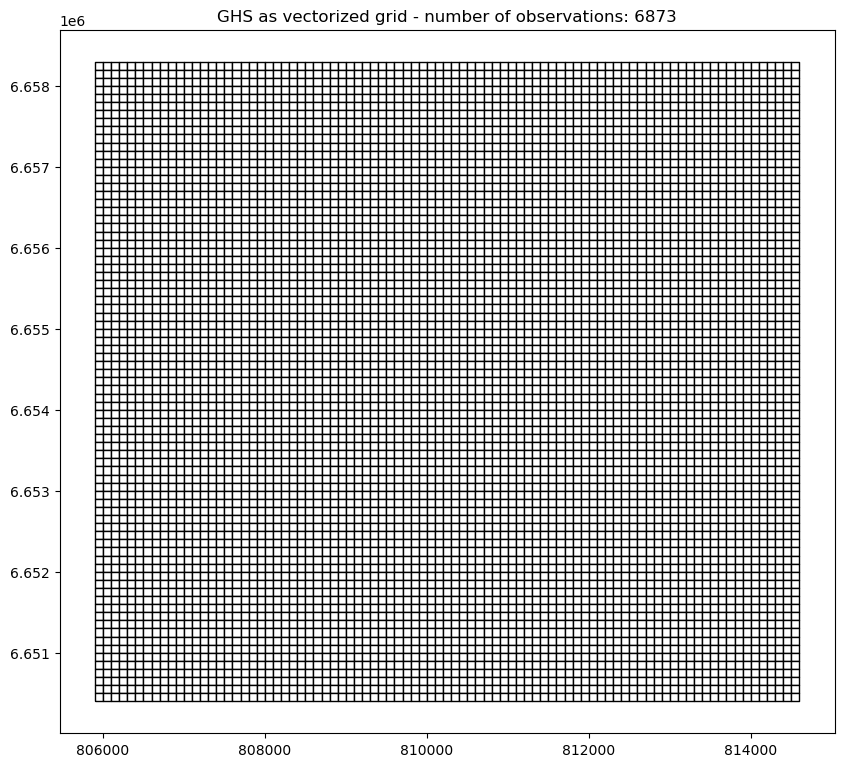

In [4]:
# 2. CONVERT AND SAVE GHS DATA AS VECTOR DATA LOCALLY
# Initialize QGIS Application
sys.path.append(qgis_path)
QgsApplication.setPrefixPath(qgis_path, True)
qgs = QgsApplication([], False)
qgs.initQgis()

# Add processing algorithms to registry
Processing.initialize()
output_layer = f'ghs_{ghs_date}_vector'

# Geopackage name
gpkg = f'PPCA1_{Name}.gpkg'

# Run and save algorithm results
processing.run("native:pixelstopolygons",
               {'INPUT_RASTER': f'ghs_{ghs_date}_export_{Name}.tif',
                'RASTER_BAND':1,
                'FIELD_NAME':'VALUE',
                'OUTPUT': f'ogr:dbname=\'{gpkg}\' table="{output_layer}" (geom)'})

# Plot results
ghs_vector = gpd.read_file(gpkg, layer = f'ghs_{ghs_date}_vector')
num_observations = len(ghs_vector)
fig, ax = plt.subplots(figsize=(10, 10))
ghs_vector.plot(ax=ax, edgecolor='black', color='white')
ax.set_title(f'GHS as vectorized grid - number of observations: {num_observations}')
plt.show()

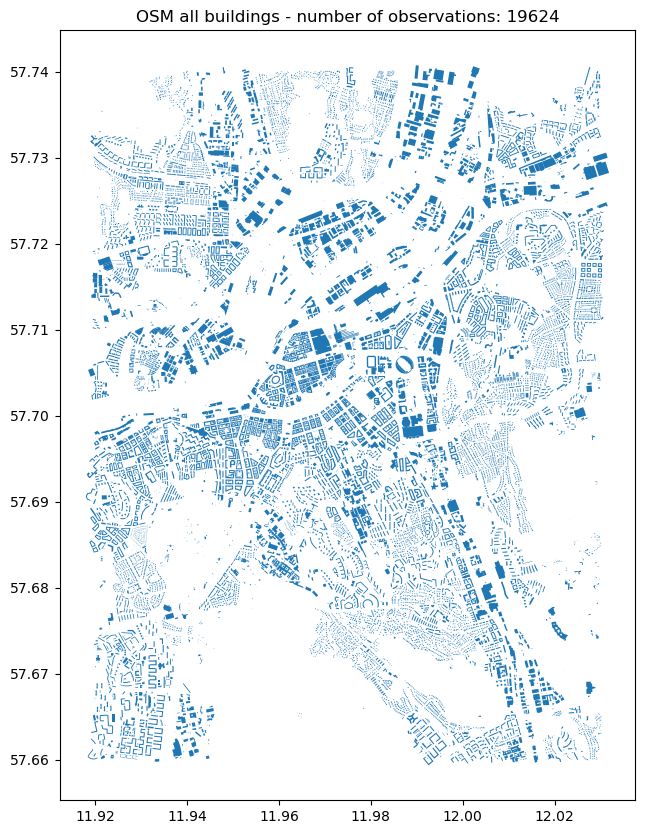

In [5]:
# 3. DOWNLOAD OSM BUILDINGS LOCALLY
# Extract buildings based on the bounding box
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom])
buildings = ox.features.features_from_polygon(polygon['geometry'][0], tags={'building': True})

#  remove list columns
list_columns = [column for column in buildings.columns if buildings[column].apply(lambda x: isinstance(x, list)).any()]
cleaned_buildings = buildings.drop(columns=list_columns)

# Remove other geometries than Polygon - keep essential columns only
cleaned_buildings = cleaned_buildings[cleaned_buildings.geom_type == 'Polygon']

# Keep essential columns only if they exist
essential_columns = ['geometry','height', 'wall', 'amenity', 'building', 'parking', 'tourism', 'shop', 'office']
existing_columns = cleaned_buildings.columns.intersection(essential_columns) 
cleaned_buildings = cleaned_buildings.loc[:, existing_columns]

# Plot & save the buildings
num_observations = len(cleaned_buildings)
fig, ax = plt.subplots(figsize=(10, 10))
cleaned_buildings.plot(ax=ax)
ax.set_title(f'OSM all buildings - number of observations: {num_observations}')
plt.show()

cleaned_buildings.to_file(gpkg, layer='osm_all_buildings', driver="GPKG")

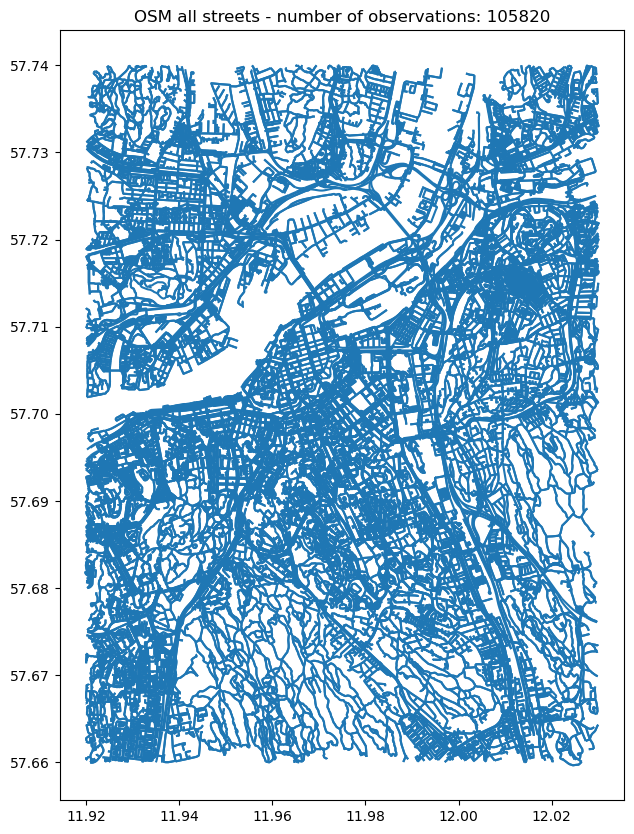

In [6]:
# 4. DOWNLOAD OSM STREETS LOCALLY
# Extract the streets based on the bounding box
# 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
G = ox.graph_from_polygon(polygon['geometry'][0], network_type='all')

# Convert graph to GeoDataFrame
linestrings_df = ox.convert.graph_to_gdfs(G)
linestrings_df = linestrings_df[1]
linestrings_gdf = gpd.GeoDataFrame(linestrings_df, geometry='geometry')

# Function to convert lists to strings
def convert_list_to_string(val):
    if isinstance(val, list):
        return ', '.join(map(str, val))
    return val

# Call the above function
for column in linestrings_gdf.columns:
    if any(isinstance(val, list) for val in linestrings_gdf[column]):
        linestrings_gdf[column] = linestrings_gdf[column].apply(convert_list_to_string)

# Keep essential columns only if they exist
essential_columns = ['geometry', 'osmid', 'highway','oneway','maxspeed','reversed','lanes','width','access','service','tunnel','bridge','junction']
existing_columns = linestrings_gdf.columns.intersection(essential_columns)
linestrings_gdf = linestrings_gdf.loc[:, existing_columns]

# Plot & save streets
linestrings_gdf.to_file(gpkg, layer='osm_all_streets', driver="GPKG")
num_observations = len(linestrings_gdf)
fig, ax = plt.subplots(figsize=(10, 10))
linestrings_gdf.plot(ax=ax)
ax.set_title(f'OSM all streets - number of observations: {num_observations}')
plt.show()

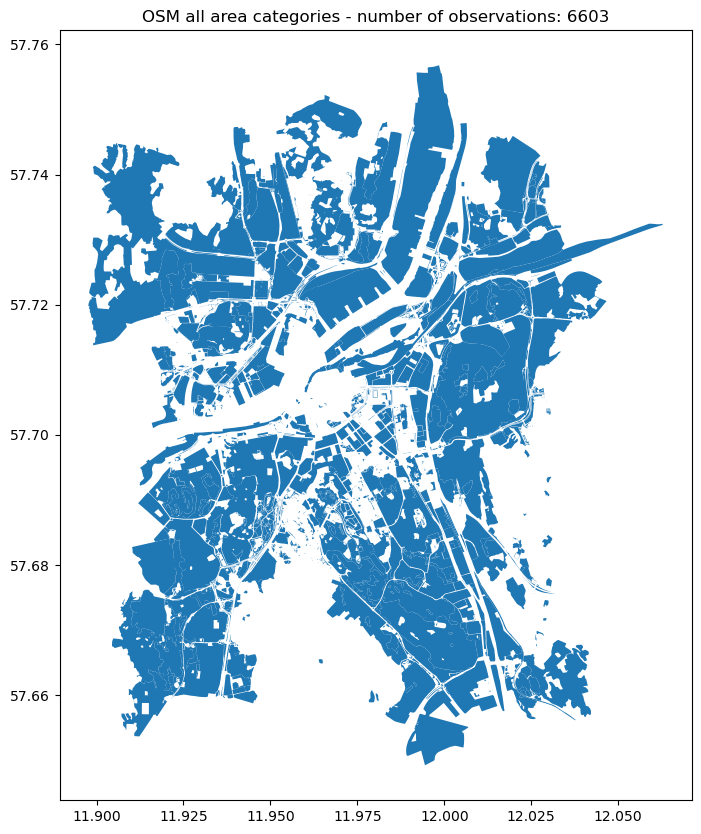

In [7]:
# 4. DOWNLOAD OSM AREA CATEGORIES LOCALLY
# Extract the area categories based on the bounding box
area_categories = ox.features.features_from_polygon(polygon['geometry'][0], tags={'landuse': True})
#  remove list columns
list_columns = [column for column in area_categories.columns if area_categories[column].apply(lambda x: isinstance(x, list)).any()]
cleaned_area_categories = area_categories.drop(columns=list_columns)

# Remove other geometries than Polygon - keep essential columns only
cleaned_area_categories = cleaned_area_categories[cleaned_area_categories.geom_type == 'Polygon']
essential_columns = ['geometry','landuse']
existing_columns = linestrings_gdf.columns.intersection(essential_columns)
cleaned_area_categories = cleaned_area_categories.loc[:, existing_columns]

# Plot & save the area categories
cleaned_area_categories.to_file(gpkg, layer='osm_all_area_categories', driver="GPKG")
num_observations = len(cleaned_area_categories)
fig, ax = plt.subplots(figsize=(10, 10))
cleaned_area_categories.plot(ax=ax)
ax.set_title(f'OSM all area categories - number of observations: {num_observations}')
plt.show()